In [1]:
import numpy as np
from astropy.io import ascii
from functions import *
from scipy.optimize import curve_fit
# from sklearn import neighbors
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pickle
import scipy

In [2]:
print("loading data")
cols = ['SFR','flag_vsquared','flag_voidfinder']
# cols = ['Mstar',
#         'u_r', 'g_r',
#         'rabsmag',
#         'SFR', 'sSFR', 'redshift',
#         'flag_vsquared',
#         'flag_voidfinder']

data = ascii.read('data_flags_updated_Nov1.dat', include_names=cols)

# Mstar = data['Mstar']
# # color
# u_r = data['u_r']
# g_r = data['g_r']
# # absolute magnitude
# rabsmag = data['rabsmag']
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
# sSFR = np.array(data['sSFR'])

print("loading classification")
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

loading data
loading classification


In [4]:
ind_gal_depth_voidv2 = np.load('ind_gal_depth_voidv2_equal_slices.npy', allow_pickle=True)
# from center to edge, increasing/cumulative number of galaxies

In [5]:
hd = fits.open('galdepth10.fits', format='ascii')
new_depths = Table(hd[1].data)
# gal_depth = new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1)]
norm_depth = new_depths['DEPTH_NORM'][(new_depths['DEPTH_NORM'] != -1)]
norm_depth = np.array(norm_depth)
# norm_depth = np.flip(np.sort(norm_depth))

# len(norm_depth)

In [6]:
avg_depth_slice=[]
# temp=[]
for i in range(len(ind_gal_depth_voidv2)):
    avg_depth_slice.append(np.average(np.flip(np.sort(norm_depth))[:len(ind_gal_depth_voidv2[i])]))
#     print(j)
#     for i in range(len(ind_gal_depth_voidv2[j])):
#         temp.append(norm_depth[np.argwhere(gal_depth == ind_gal_depth_voidv2[j][i])])
#     avg_depth_slice.append(np.average(temp))
#     temp=[]

In [7]:
avg_depth_slice = np.flip(avg_depth_slice)

In [8]:
# print(ampl_ratio_err(5,3,4,2),ampl_ratio_err(5,2,4,3))
# print(ampl_ratio_err(5,20,4,10),ampl_ratio_err(5,10,4,20))
# print(ampl_ratio_err(5,20,4,10),ampl_ratio_err(5,10,4,20))

In [9]:
def ampl_ratio_err(x,dx,y,dy):
    '''
    returns the standard deviation of x/y
    '''
    return np.sqrt((dx/y)**2+((x*dy)/(y**2))**2) # x>y always, if dx>dy, d(x/y) small , if dy>dx, d(x/y) big
    
# def ampl_diff_err(dx,dy):
#     '''
#     returns the standard deviation of x-y
#     '''
#     return np.sqrt(dx**2 + dy**2)  

In [10]:

def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
# def func_bimodal(x, a, mua, sga,b, mub, sgb):
#     '''returns a mixture of two skewnormal distributions'''
#     return a*norm.pdf(x, loc=mua, scale=sga) + b*norm.pdf(x, loc=mub, scale=sgb)


In [11]:
def func_bimodal1(x,a, mua, sga,askew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga)
# def func_bimodal1(x,a, mua, sga):
#     '''returns a mixture of two skewnormal distributions'''
#     return a*norm.pdf(x, loc=mua, scale=sga)

In [12]:
def bin_data(data,bins_,label, plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot == True:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title("Binned Data ")
        plt.show()
            
# #     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
#     popt_void, pcov_void = curve_fit(func_bimodal, x, n1)

        
#     plt.errorbar(x, n1, yerr=dn1, fmt='.')  
#     plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
#     plt.title(label + " Void")
#     plt.xlabel(label)
#     plt.ylabel("Counts")
#     plt.show()
    
#     print(popt_void)
#     print(*popt_void)
        
    return  x,n1,dn1 #, popt_void

In [13]:
def bimodal_fit_void_separate(char_void, label, bins_,bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, 0, 1,np.inf,np.inf,np.inf,1,np.inf))
 ):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
#     x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
#     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
# a, mua, sga, askew, b, mub, sgb, bskew
# bounds=((-np.inf, -np.inf, 0,-np.inf,-np.inf,-np.inf,0,-np.inf), (-np.inf, -np.inf, 1,-np.inf,-np.inf,-np.inf,1,-np.inf))

    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void, bounds=bounds_)
    
#     #begin test
#     print(popt_void)
#     plt.plot(x, count_void)
#     plt.show()
#     #end test
        
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  
    plt.plot(x, func_bimodal1(x, *popt_void[:4]), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal1(x, *popt_void[4:]), 'g-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal(x, *popt_void), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))

    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
 

    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_void, np.sqrt(np.diag(pcov_void))
    

In [14]:
# a1 = max_min_all(fit_all)[0]
# b1 = max_min_all(fit_all)[1]
def max_min(fit_result):
#     print(scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][:4])).hess)
    x1 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][:4])).x
    x2 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][4:])).x
    y1 = func_bimodal(x1,*fit_result[0])
    y2 = func_bimodal(x2,*fit_result[0])
    return np.max([y1,y2]), np.min([y1,y2])

In [15]:
fit_all = bimodal_fit_void_separate(SFR[data['redshift']< 0.1026], 'SFR', bins_=np.linspace(-3,2, 250))
VF_void = bimodal_fit_void_separate(SFR[void_vf], 'SFR', bins_=np.linspace(-3,2, 250), 
bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,-0.2,0,-np.inf), (np.inf, -0.9, 1.5,np.inf,np.inf,np.inf,1.5,np.inf)))


KeyError: 'redshift'

In [ ]:
#normalized by the general distribution
amplitude_ratio = []
amplitude_ratio_err = []
ind_big=[]
ind_small = []

# amplitude_diff = []
# amplitude_diff_err = []
# x_n = max_min(fit_all)[0] #max
# y_n = max_min(fit_all)[1]

index_pass = []
avg_depth = []
for i in range(len(ind_gal_depth_voidv2)):
    print(i)
    try:
        if i < 12:
            temp = bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250),bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, -0.9, 1.5,np.inf,np.inf,np.inf,1.5,np.inf)))
        else:
            temp = bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250),bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, 0, 1.5,np.inf,np.inf,np.inf,1.5,np.inf)))

#         print(temp[0][0],temp[0][4],temp[1][0],temp[1][4])
        temp1 = max_min(temp)
        x = temp1[0]#/x_n #max
        y = temp1[1]#/y_n #min
        
        if temp[0][0]<temp[0][4]:
            dx = temp[1][4]
            dy = temp[1][0]
        if temp[0][0]>temp[0][4]:
            dx = temp[1][0]
            dy = temp[1][4]
#         if x == temp[0][4]:
#             dx = temp[1][4]/np.max([fit_all[0][4],fit_all[0][0]])
#             dy = temp[1][0]/np.min([fit_all[0][4],fit_all[0][0]])

#         if x == temp[0][0]:
#             dx = temp[1][0]/np.max([fit_all[0][4],fit_all[0][0]])
#             dy = temp[1][4]/np.min([fit_all[0][4],fit_all[0][0]])
            
#         x = x/np.max([fit_all[0][4],fit_all[0][0]])
#         y = y/np.min([fit_all[0][4],fit_all[0][0]])
        if dy>dx:
            ind_big.append(i)
        if dy<dx:
            ind_small.append(i)            
        amplitude_ratio.append(x/y)
#         amplitude_diff.append(x-y)
        amplitude_ratio_err.append(ampl_ratio_err(x,dx,y,dy))
#         amplitude_diff_err.append(ampl_diff_err(dx,dy))
#         print(temp[0][0],temp[1][0],temp[0][4],temp[1][4], x,dx)
        
    except (RuntimeError):
        index_pass.append(i)
        pass


In [ ]:
amplitude_ratio = np.array(amplitude_ratio)
amplitude_ratio_err = np.array(amplitude_ratio_err)
# amplitude_diff = np.array(amplitude_diff)
# amplitude_diff_err = np.array(amplitude_diff_err)


In [16]:
x_ratio= np.delete(avg_depth_slice, index_pass)
# x_diff= np.delete(avg_depth_slice, index_pass)

NameError: name 'index_pass' is not defined

In [17]:
len(ind_gal_depth_voidv2) - len(index_pass) == len(amplitude_ratio)

NameError: name 'index_pass' is not defined

In [18]:
ind_ratio=0 # choose
ind_diff=0 # choose


In [19]:
dx_vf_void = np.max([VF_void[1][4],VF_void[1][0]]) #max
dy_vf_void = np.min([VF_void[1][4],VF_void[1][0]])

dx_fit_all = np.max([fit_all[1][4],fit_all[1][0]]) #max
dy_fit_all = np.min([fit_all[1][4],fit_all[1][0]])

x_vf_void=max_min(VF_void)[0]
y_vf_void=max_min(VF_void)[1]

x_fit_all=max_min(fit_all)[0]
y_fit_all=max_min(fit_all)[1]

ratio_err_vf_void = ampl_ratio_err(x_vf_void,dx_vf_void,y_vf_void,dy_vf_void)

NameError: name 'VF_void' is not defined

In [20]:
dx_vf_void = np.max([VF_void[1][4],VF_void[1][0]]) #max
dy_vf_void = np.min([VF_void[1][4],VF_void[1][0]])

dx_fit_all = np.max([fit_all[1][4],fit_all[1][0]]) #max
dy_fit_all = np.min([fit_all[1][4],fit_all[1][0]])

x_vf_void=max_min(VF_void)[0]
y_vf_void=max_min(VF_void)[1]

x_fit_all=max_min(fit_all)[0]
y_fit_all=max_min(fit_all)[1]

ratio_err_vf_void = ampl_ratio_err(x_vf_void,dx_vf_void,y_vf_void,dy_vf_void)
ratio_err_fit_all = ampl_ratio_err(x_fit_all,dx_fit_all,y_fit_all,dy_fit_all)


NameError: name 'VF_void' is not defined

In [ ]:
x_vf_void,dx_vf_void

In [ ]:
y_vf_void_ratio= []
y_vf_void_diff = []

y_vf_void_ratio_err=[]
for i in range(len(x_ratio[ind_ratio:])):
    y_vf_void_ratio.append(x_vf_void/y_vf_void)
    y_vf_void_ratio_err.append(ratio_err_vf_void)
# for i in range(len(x_diff)):
# # for i in range(2):
#     y_vf_void_diff.append(max_min(VF_void)[0]-max_min(VF_void)[1])

    
all_ratio= []
# all_diff = []
y_fit_all_ratio_err=[]

for i in range(len(x_ratio[ind_ratio:])):
    all_ratio.append(x_fit_all/y_fit_all)
    y_fit_all_ratio_err.append(ratio_err_fit_all)
# for i in range(len(x_diff)):
# # for i in range(2):
#     all_diff.append(max_min(fit_all)[0]-max_min(fit_all)[1])

In [ ]:
len(amplitude_ratio), len(x_ratio)#, len(y_vf_void_ratio), len(all_ratio)

In [ ]:
(y_vf_void_ratio- y_vf_void_ratio_err[0])[0]

In [ ]:
plt.figure(figsize=(14, 9))

# plt.errorbar(x_ratio,amplitude_ratio[ind_ratio:],yerr=amplitude_ratio_err[ind_ratio:] ,fmt= '-o')
plt.errorbar(np.flip(x_ratio[ind_ratio:]),amplitude_ratio[ind_ratio:], yerr=amplitude_ratio_err[ind_ratio:], color='black', label="$V^{2}$ Void", linestyle='dashed')
plt.plot(x_ratio,y_vf_void_ratio, label="VoidFinder Void", c="red")
plt.plot(x_ratio,all_ratio, label="All",c="gray")
plt.fill_between(np.flip(x_ratio), (y_vf_void_ratio- y_vf_void_ratio_err[0]), (y_vf_void_ratio+y_vf_void_ratio_err[0]), color='red', alpha=.1)
plt.fill_between(np.flip(x_ratio), (all_ratio- y_fit_all_ratio_err[0]), (all_ratio+y_fit_all_ratio_err[0]), color='gray', alpha=.1)


plt.xlabel("Normalized distance to the edge",fontsize=18)
plt.ylabel("high SF mode to low SF mode",fontsize=18)
plt.title("Star formation rate",fontsize=18)
plt.xlim(np.max(x_ratio[ind_ratio:])+0.005, np.min(x_ratio[ind_ratio:])-0.005)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()


# # plt.errorbar(x_diff,amplitude_diff[ind_diff:],yerr=amplitude_diff_err[ind_diff:] ,fmt= '-o')
# plt.plot(x_diff,np.flip(amplitude_diff[ind_diff:]))
# plt.plot(x_diff,y_vf_void_diff, label="VoidFinder Void", c="green")
# plt.plot(x_ratio,all_diff,label="All",c="orange")

# # error bars get bigger as x,y gets bigger
# plt.xlabel("distance to edge (accumulative)",fontsize=15)
# plt.ylabel("peak difference",fontsize=15)
# plt.legend()
# plt.show()

In [49]:
#explain it well in caption/description (cumulative, mention error bars)
# 20 bins for paper
# cross points , remove dashed lines 

In [47]:
# small error bars = dx>dy
np.array(ind_big), np.array(ind_small)

(array([ 3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([0, 1, 2, 4]))

In [27]:
print(amplitude_ratio_err)

[0.25530645 0.09762945 0.26513965 0.12702894 0.1102155  0.10553119
 0.23103663 0.08667857 0.17138702 0.16102511 0.06667545 0.06880991
 0.06918563 0.13392383 0.12069261 0.11005224 0.10649603 0.10153856
 0.09757857 0.10264065 0.08915537 0.09119571 0.08671244 0.0815855
 0.07927625 0.07562672 0.08300968 0.07401509 0.08058453 0.07462101
 0.06848772 0.07597489 0.06697081 0.06648627 0.06367775 0.06277411
 0.06200262 0.06080684 0.06674419 0.06627044 0.05874299 0.05784132
 0.05739121 0.0617602  0.05567867 0.07696573 0.07388483 0.0389977
 0.03813926 0.06848016]


In [ ]:
plt.scatter(amplitude_ratio_err[(-amplitude_ratio_err).argsort()[:6]])

In [82]:
print(amplitude_ratio_err)

[0.25530645 0.09762945 0.26513965 0.13464173 0.11756867 0.11170176
 0.23103663 0.09169848 0.17138702 0.16102511 0.07113978 0.07265354
 0.07287824 0.13392383 0.12069261 0.11005224 0.10649603 0.10153856
 0.09757857 0.10264065 0.08915537 0.09119571 0.08671244 0.0815855
 0.07927625 0.07562672 0.08300968 0.07401509 0.08058453 0.07462101
 0.06848772 0.07597489 0.06697081 0.06648627 0.06367775 0.06277411
 0.06200262 0.06080684 0.06674419 0.06627044 0.05874299 0.05784132
 0.05739121 0.0617602  0.05567867 0.07696573 0.07388483 0.0389977
 0.03813926 0.06848016]


0
loading property model variables


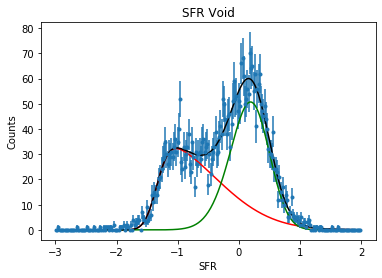

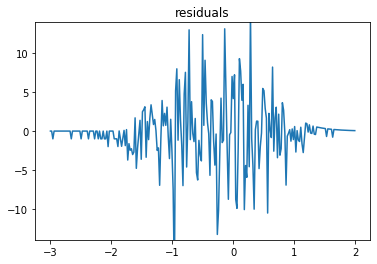

(array([40.92291835, -1.34145795,  0.93085552,  5.80508016, 41.02463216,
        0.41543389,  0.41819738, -1.24824156]), array([4.06659262, 0.01572711, 0.11073229, 1.17896163, 3.61066446,
       0.0367607 , 0.03850924, 0.32266603]))
1
loading property model variables


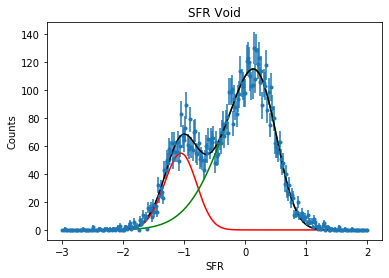

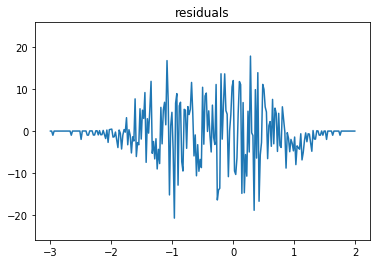

(array([ 36.2028437 ,  -0.9       ,   0.31289835,  -0.90138515,
       127.16339964,   0.48275646,   0.69105735,  -2.43767649]), array([3.27848166, 0.0748367 , 0.0480846 , 0.64494203, 3.4394297 ,
       0.01744311, 0.04290956, 0.3108637 ]))
2
loading property model variables


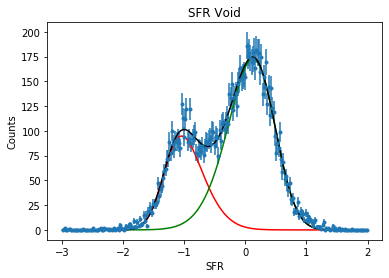

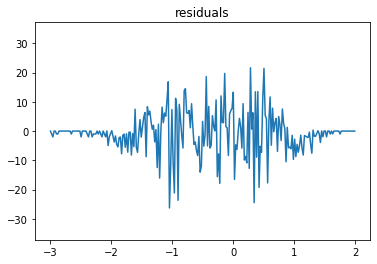

(array([ 76.28130877,  -1.28969439,   0.46516036,   1.82556023,
       168.32569634,   0.41464672,   0.53207983,  -1.51834731]), array([13.37416289,  0.03942774,  0.11442606,  0.78416119, 13.34260102,
        0.04210189,  0.08573888,  0.48152767]))
3
loading property model variables


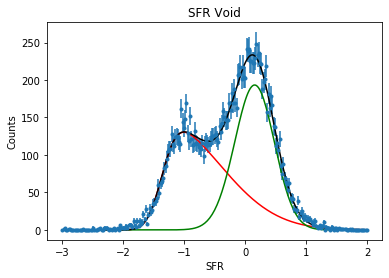

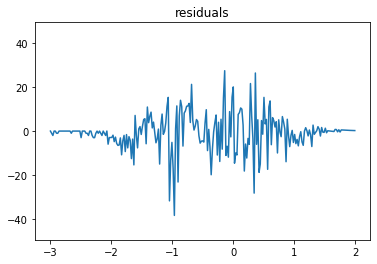

(array([170.05445672,  -1.36025789,   0.93333618,   4.73522103,
       157.28827448,   0.29241677,   0.35503366,  -0.58556188]), array([8.86200171, 0.0102281 , 0.06301107, 0.53454254, 7.91804885,
       0.08219824, 0.03830505, 0.40544918]))
4
loading property model variables


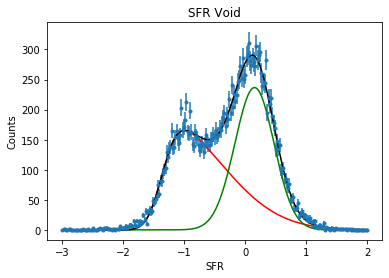

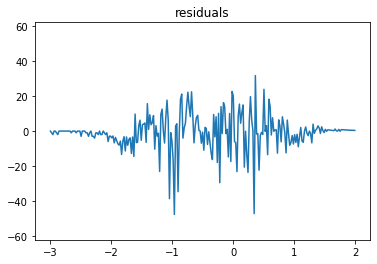

(array([219.56777368,  -1.35882387,   0.95208486,   4.7376375 ,
       190.61554033,   0.27045286,   0.34336368,  -0.49085188]), array([9.95767706e+00, 9.82184293e-03, 5.60863620e-02, 4.84585622e-01,
       8.75906559e+00, 1.15384255e-01, 4.46487243e-02, 5.38036109e-01]))
5
loading property model variables


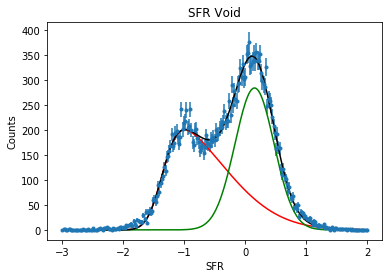

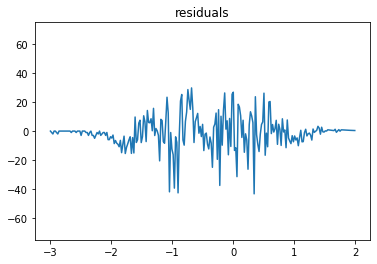

(array([ 2.63550441e+02, -1.35339595e+00,  9.37525809e-01,  4.58776430e+00,
        2.27857058e+02,  1.52422124e-01,  3.20130636e-01,  2.68935473e-03]), array([1.15624368e+01, 9.29609704e-03, 5.49969084e-02, 4.56070591e-01,
       1.03060022e+01, 3.38247207e+03, 7.25860138e+00, 1.32425126e+04]))
6
loading property model variables


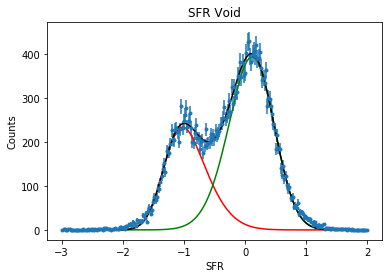

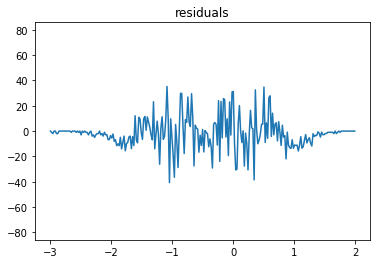

(array([ 2.02617725e+02, -1.29455985e+00,  5.10794441e-01,  1.95510576e+00,
        3.67532476e+02,  3.61069205e-01,  4.67970642e-01, -1.11835011e+00]), array([28.85764756,  0.03155389,  0.1080263 ,  0.68304591, 28.75737601,
        0.05438238,  0.07696504,  0.44596614]))
7
loading property model variables


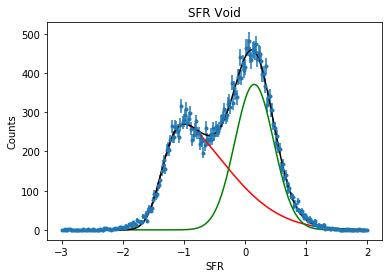

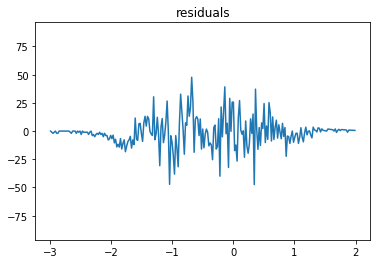

(array([ 3.59587310e+02, -1.36336651e+00,  9.51567672e-01,  4.67236073e+00,
        2.96635966e+02,  3.68833161e-02,  3.39715807e-01,  4.77274422e-01]), array([1.29992337e+01, 7.77356790e-03, 4.63457419e-02, 3.89570193e-01,
       1.15563110e+01, 9.50534715e-02, 3.64797257e-02, 4.39812615e-01]))
8
loading property model variables


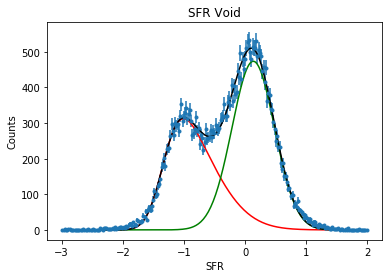

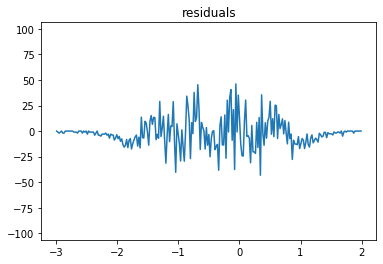

(array([ 3.20981935e+02, -1.32859672e+00,  6.68762738e-01,  2.86781730e+00,
        4.13491416e+02,  1.35744431e-01,  3.48308302e-01, -3.00404899e-03]), array([2.84636760e+01, 1.76457723e-02, 9.03536296e-02, 5.91059009e-01,
       2.81739697e+01, 3.73741569e+03, 8.96720524e+00, 1.34484750e+04]))
9
loading property model variables


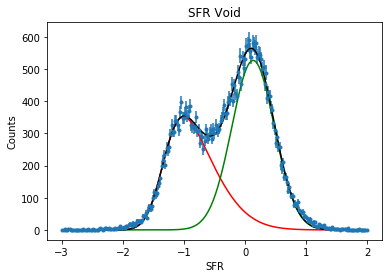

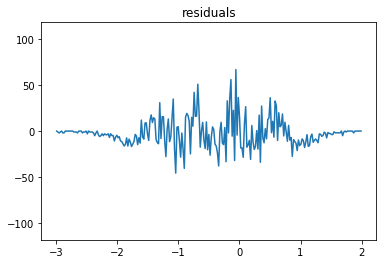

(array([ 3.55588345e+02, -1.32566235e+00,  6.52274854e-01,  2.74100147e+00,
        4.60909953e+02,  1.32819598e-01,  3.49065651e-01, -2.22371656e-03]), array([3.04035554e+01, 1.80961597e-02, 8.65760833e-02, 5.61514345e-01,
       3.01242731e+01, 6.92137264e+03, 1.22893640e+01, 2.48512419e+04]))


In [33]:
i=0
while i < 10:
    print(i)
    print(bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250),bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, -0.9, 1.5,np.inf,np.inf,np.inf,1.5,np.inf))))
    i+=1
#         else:
#             temp = bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250),bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, 0, 1.5,np.inf,np.inf,np.inf,1.5,np.inf)))


loading property model variables


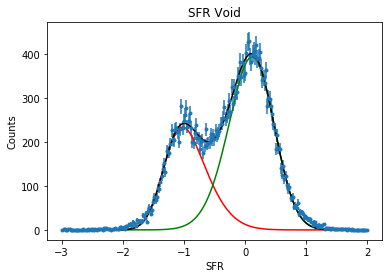

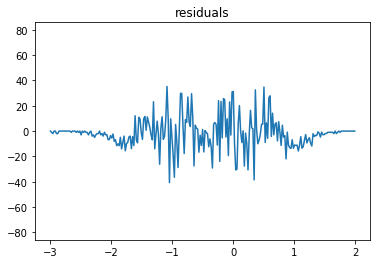

(array([ 2.02617725e+02, -1.29455985e+00,  5.10794441e-01,  1.95510576e+00,
        3.67532476e+02,  3.61069205e-01,  4.67970642e-01, -1.11835011e+00]), array([28.85764756,  0.03155389,  0.1080263 ,  0.68304591, 28.75737601,
        0.05438238,  0.07696504,  0.44596614]))


In [56]:
test = bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[6]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250),bounds_=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, -0.9, 1.5,np.inf,np.inf,np.inf,1.5,np.inf)))
print(test)

In [57]:
if test[0][1]<test[0][4]:
    dx = test[1][4]
    dy = test[1][0]
if test[0][1]>test[0][4]:
    dx = test[1][0]
    dy = test[1][4]
dx,dy

(28.757376005268434, 28.85764756454848)

In [42]:
max_min(test)[0],test[0][4]

(115.1376282603542, 127.16339964328805)

In [61]:
amplitude_ratio_err

array([0.23938796, 0.09762945, 0.26482686, 0.12702894, 0.1102155 ,
       0.10553119, 0.23066155, 0.08667857, 0.17060658, 0.16038265,
       0.06667545, 0.06880991, 0.06918563, 0.13356108, 0.12031598,
       0.10972015, 0.10617701, 0.10125869, 0.0973276 , 0.10239464,
       0.0889451 , 0.09098285, 0.08652108, 0.0814084 , 0.07911161,
       0.07547043, 0.08284961, 0.07387297, 0.08043289, 0.07458516,
       0.06836676, 0.07586399, 0.06686144, 0.06638063, 0.06358024,
       0.06268095, 0.06191499, 0.0607249 , 0.06665951, 0.06618975,
       0.0586743 , 0.05777695, 0.05732971, 0.06168828, 0.05562417,
       0.0769287 , 0.07385289, 0.0389977 , 0.03813926, 0.06845647])

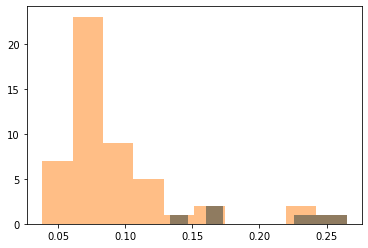

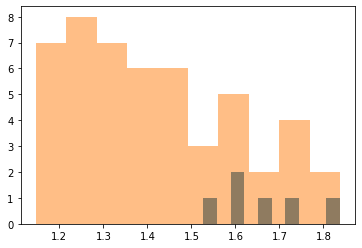

In [95]:
plt.hist(amplitude_ratio_err[(-amplitude_ratio_err).argsort()[:6]])
plt.hist(amplitude_ratio_err,alpha=0.5)

plt.show()
plt.hist(amplitude_ratio[(-amplitude_ratio_err).argsort()[:6]])
plt.hist(amplitude_ratio, alpha=0.5)
plt.show()

In [92]:
amplitude_ratio_err[(-amplitude_ratio_err).argsort()[:15]]

array([0.26482686, 0.23938796, 0.23066155, 0.17060658, 0.16038265,
       0.13356108, 0.12702894, 0.12031598, 0.1102155 , 0.10972015,
       0.10617701, 0.10553119, 0.10239464, 0.10125869, 0.09762945])

In [80]:
plt.hist??

In [33]:
#solid line inside the shaded areas (DONE)
# why are the error bars huge every 3 -4 bins?
# try 25 bins with equal amount of galaxies, still start close to the center of the void
# smaller bin error bars have about the same size,?
# push to git repository